In [15]:
import pandas as pd

# 1. Load the three CSV files
daily = pd.read_csv(r"C:\Users\shara\Downloads\data science project\daily_reminder.csv")
health = pd.read_csv(r"C:\Users\shara\Downloads\data science project\health_monitoring.csv")
safety = pd.read_csv(r"C:\Users\shara\Downloads\data science project\safety_monitoring.csv")

# 2. Quick peek at each DataFrame’s first rows and dtypes
print("=== Daily Reminder ===")
print(daily.head(), "\n", daily.dtypes, "\n")

print("=== Health Monitoring ===")
print(health.head(), "\n", health.dtypes, "\n")

print("=== Safety Monitoring ===")
print(safety.head(), "\n", safety.dtypes, "\n")


=== Daily Reminder ===
  Device-ID/User-ID       Timestamp Reminder Type Scheduled Time  \
0             D1000  1/2/2025 11:25      Exercise       13:00:00   
1             D1001   1/3/2025 2:52     Hydration       13:00:00   
2             D1002  1/8/2025 13:50   Appointment       13:30:00   
3             D1003   1/5/2025 5:16      Exercise        8:00:00   
4             D1004   1/1/2025 4:20    Medication       11:30:00   

  Reminder Sent (Yes/No) Acknowledged (Yes/No)  Unnamed: 6  
0                     No                    No         NaN  
1                    Yes                   Yes         NaN  
2                     No                    No         NaN  
3                     No                    No         NaN  
4                     No                    No         NaN   
 Device-ID/User-ID          object
Timestamp                  object
Reminder Type              object
Scheduled Time             object
Reminder Sent (Yes/No)     object
Acknowledged (Yes/No)      obj

In [17]:
# Define a helper to clean column names:
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r"[ %\-\/]", "_", regex=True)   # replace spaces, %, -, / with underscore
        .str.replace(r"[^a-z0-9_]", "", regex=True)  # remove any other special chars
    )
    return df

daily = clean_column_names(daily)
health = clean_column_names(health)
safety = clean_column_names(safety)

# Rename “deviceiduserid” to “user_id” for readability
for df in (daily, health, safety):
    if "deviceiduserid" in df.columns:
        df.rename(columns={"deviceiduserid": "user_id"}, inplace=True)


In [19]:
# Convert each “timestamp” column to pandas datetime (coercing invalid parses to NaT)
for df in (daily, health, safety):
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")


In [21]:
# Helper to map “Yes” → 1, “No” → 0 (other values become NaN)
def map_yes_no(s: pd.Series) -> pd.Series:
    return s.map({"Yes": 1, "No": 0})

# List all Yes/No columns in each DataFrame (after cleaning names)
daily_yesno = ["reminder_sent_yesno", "acknowledged_yesno"]
health_yesno = [
    "heart_rate_belowabove_threshold_yesno",
    "blood_pressure_belowabove_threshold_yesno",
    "glucose_levels_belowabove_threshold_yesno",
    "spo2_below_threshold_yesno",
    "alert_triggered_yesno",
    "caregiver_notified_yesno",
]
safety_yesno = ["fall_detected_yesno", "alert_triggered_yesno", "caregiver_notified_yesno"]

for col in daily_yesno:
    if col in daily.columns:
        daily[col] = map_yes_no(daily[col])

for col in health_yesno:
    if col in health.columns:
        health[col] = map_yes_no(health[col])

for col in safety_yesno:
    if col in safety.columns:
        safety[col] = map_yes_no(safety[col])


In [25]:
# (Assuming you have already loaded and cleaned column names as before)

# 1. Drop any "unnamed_*" columns automatically
for df in (daily, health, safety):
    unnamed_cols = [c for c in df.columns if c.startswith("unnamed")]
    df.drop(columns=unnamed_cols, inplace=True)

# 2. Rename "device_id_user_id" to "user_id" if not already done
for df in (daily, health, safety):
    if "device_id_user_id" in df.columns:
        df.rename(columns={"device_id_user_id": "user_id"}, inplace=True)

# 3. Now check missing values again
print("Missing in daily:\n", daily.isna().sum(), "\n")
print("Missing in health:\n", health.isna().sum(), "\n")
print("Missing in safety:\n", safety.isna().sum(), "\n")

# 4. Drop rows missing critical keys: user_id or timestamp
daily.dropna(subset=["user_id", "timestamp"], inplace=True)
health.dropna(subset=["user_id", "timestamp"], inplace=True)
safety.dropna(subset=["user_id", "timestamp"], inplace=True)

# 5. (Optional) If you see missing in other important columns,
#    decide whether to impute or drop—e.g. you might fill missing vitals by forward‐fill.


Missing in daily:
 user_id                 0
timestamp               0
reminder_type           0
scheduled_time          0
reminder_sent_yes_no    0
acknowledged_yes_no     0
dtype: int64 

Missing in health:
 user_id                                        0
timestamp                                      0
heart_rate                                     0
heart_rate_below_above_threshold_yes_no        0
blood_pressure                                 0
blood_pressure_below_above_threshold_yes_no    0
glucose_levels                                 0
glucose_levels_below_above_threshold_yes_no    0
oxygen_saturation_spo_                         0
spo_below_threshold_yes_no                     0
alert_triggered_yes_no                         0
caregiver_notified_yes_no                      0
dtype: int64 

Missing in safety:
 user_id                                  0
timestamp                                0
movement_activity                        0
fall_detected_yes_no                  

In [27]:
# Step 6: Drop exact duplicates in each DataFrame
for df, name in [(daily, "daily"), (health, "health"), (safety, "safety")]:
    before = len(df)
    df.drop_duplicates(inplace=True)
    after = len(df)
    print(f"Dropped {before - after} duplicate rows from {name} sheet.")


Dropped 0 duplicate rows from daily sheet.
Dropped 0 duplicate rows from health sheet.
Dropped 0 duplicate rows from safety sheet.


In [29]:
# Step 7: Sort & reset index

# Sort by user_id, then timestamp
daily.sort_values(["user_id", "timestamp"], inplace=True)
health.sort_values(["user_id", "timestamp"], inplace=True)
safety.sort_values(["user_id", "timestamp"], inplace=True)

# Reset the index to clean up after sorting
daily.reset_index(drop=True, inplace=True)
health.reset_index(drop=True, inplace=True)
safety.reset_index(drop=True, inplace=True)

# Optional: print the first few rows to verify sorting
print(daily.head())
print(health.head())
print(safety.head())


  user_id           timestamp reminder_type scheduled_time  \
0   D1000 2025-01-02 11:25:00      Exercise       13:00:00   
1  D10000 2025-01-21 00:04:00    Medication       16:30:00   
2  D10001 2025-01-22 13:52:00   Appointment       14:30:00   
3  D10002 2025-01-26 11:12:00    Medication       15:30:00   
4  D10003 2025-01-09 15:50:00     Hydration       10:30:00   

  reminder_sent_yes_no acknowledged_yes_no  
0                   No                  No  
1                   No                  No  
2                  Yes                 Yes  
3                  Yes                 Yes  
4                  Yes                 Yes  
  user_id           timestamp  heart_rate  \
0   D1000 2025-01-22 20:42:00         116   
1  D10000 2025-01-24 01:43:00         119   
2  D10001 2025-01-23 14:20:00          76   
3  D10002 2025-01-22 05:01:00          74   
4  D10003 2025-01-01 16:40:00          94   

  heart_rate_below_above_threshold_yes_no blood_pressure  \
0                         

In [33]:
import pandas as pd



# 1a. Show info() for each DataFrame
print("=== Daily Reminder Info ===")
print(daily.info(), "\n")
print("=== Health Monitoring Info ===")
print(health.info(), "\n")
print("=== Safety Monitoring Info ===")
print(safety.info(), "\n")

# 1b. Show descriptive statistics
print("=== Daily Reminder Descriptive Stats ===")
print(daily.describe(include="all"), "\n")

print("=== Health Monitoring Descriptive Stats ===")
print(health.describe(), "\n")

print("=== Safety Monitoring Descriptive Stats ===")
print(safety.describe(include="all"), "\n")


=== Daily Reminder Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               10000 non-null  object        
 1   timestamp             10000 non-null  datetime64[ns]
 2   reminder_type         10000 non-null  object        
 3   scheduled_time        10000 non-null  object        
 4   reminder_sent_yes_no  10000 non-null  object        
 5   acknowledged_yes_no   10000 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 468.9+ KB
None 

=== Health Monitoring Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   user_id                    

In [35]:
# Step 2: Count unique users in each DataFrame
num_daily_users = daily["user_id"].nunique()
num_health_users = health["user_id"].nunique()
num_safety_users = safety["user_id"].nunique()

print(f"Unique users in Daily Reminder: {num_daily_users}")
print(f"Unique users in Health Monitoring: {num_health_users}")
print(f"Unique users in Safety Monitoring: {num_safety_users}")


Unique users in Daily Reminder: 10000
Unique users in Health Monitoring: 10000
Unique users in Safety Monitoring: 10000


In [39]:
# EDA Step 3: Reminder Acknowledgement Rate



# 1. Calculate the percentage of times reminders were acknowledged vs. not
ack_counts = daily['acknowledged_yes_no'].value_counts(normalize=True) * 100

# 2. Prepare a small summary DataFrame for easy viewing
ack_rate_df = (
    ack_counts
    .rename_axis('acknowledged')      # index name becomes “acknowledged”
    .reset_index(name='percentage')   # bring index into column “acknowledged”
)

print("Reminder Acknowledgement Rate (%):")
print(ack_rate_df)


Reminder Acknowledgement Rate (%):
  acknowledged  percentage
0           No       60.38
1          Yes       39.62


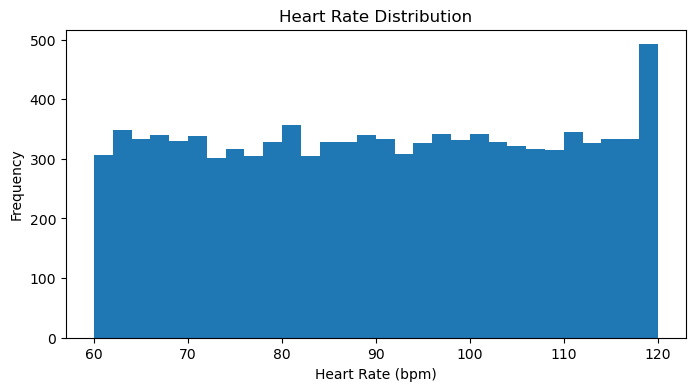

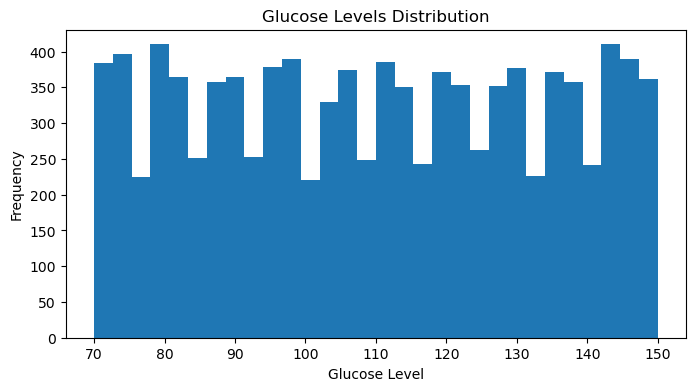

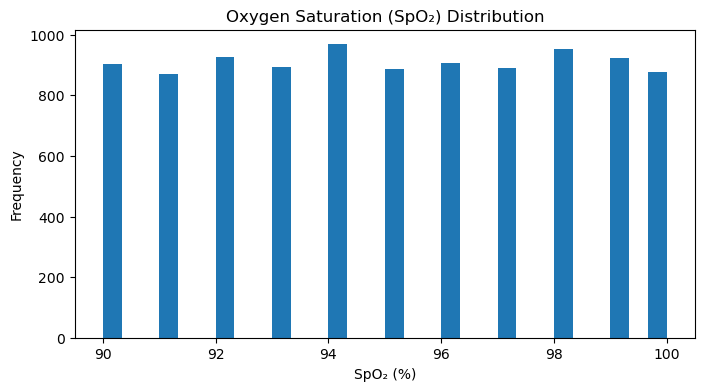

In [43]:
import matplotlib.pyplot as plt

# (Assuming `health` is already in memory from the cleaning phase.)

# 1. Heart Rate distribution
plt.figure(figsize=(8, 4))
plt.hist(health['heart_rate'].dropna(), bins=30)
plt.title('Heart Rate Distribution')
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Frequency')
plt.show()

# 2. Glucose Levels distribution
plt.figure(figsize=(8, 4))
plt.hist(health['glucose_levels'].dropna(), bins=30)
plt.title('Glucose Levels Distribution')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

# 3. Oxygen Saturation (SpO₂) distribution
plt.figure(figsize=(8, 4))
plt.hist(health['oxygen_saturation_spo_'].dropna(), bins=30)
plt.title('Oxygen Saturation (SpO₂) Distribution')
plt.xlabel('SpO₂ (%)')
plt.ylabel('Frequency')
plt.show()


Fall Detection Counts:
fall_detected_yes_no
No     9501
Yes     499
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1838749601.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [fall_counts.get(0, 0), fall_counts.get(1, 0)],


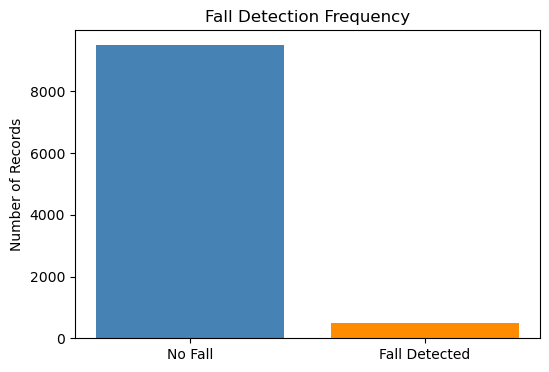

In [45]:
import pandas as pd
import matplotlib.pyplot as plt



# 1. Count how many “Yes” vs. “No” in fall_detected_yes_no
fall_counts = safety["fall_detected_yes_no"].value_counts()

print("Fall Detection Counts:")
print(fall_counts)

# 2. Visualize with a bar chart
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Fall", "Fall Detected"],
    [fall_counts.get(0, 0), fall_counts.get(1, 0)],
    color=["steelblue", "darkorange"]
)
plt.title("Fall Detection Frequency")
plt.ylabel("Number of Records")
plt.show()


Reminder Type Counts:
reminder_type
Appointment    2544
Hydration      2525
Medication     2516
Exercise       2415
Name: count, dtype: int64


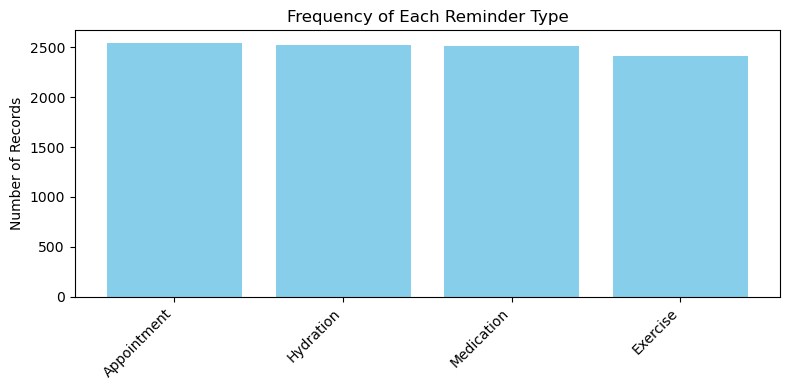

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# (Assume `daily` is in memory; otherwise reload cleaned CSV)
# daily = pd.read_csv(r"C:\Users\shara\Downloads\data science project\daily_reminder_cleaned.csv")

# Count each reminder type
reminder_counts = daily['reminder_type'].value_counts()

print("Reminder Type Counts:")
print(reminder_counts)

# Bar plot of reminder types
plt.figure(figsize=(8, 4))
plt.bar(reminder_counts.index, reminder_counts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of Each Reminder Type")
plt.ylabel("Number of Records")
plt.tight_layout()
plt.show()


Health: Alert Triggered Counts (No=0, Yes=1):
alert_triggered_yes_no
Yes    7367
No     2633
Name: count, dtype: int64

Health: Caregiver Notified Counts (No=0, Yes=1):
caregiver_notified_yes_no
Yes    7367
No     2633
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1100469388.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [health_alert_counts.get(0, 0), health_alert_counts.get(1, 0)],


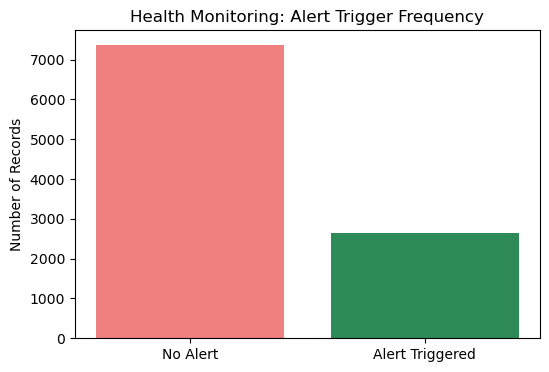

C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1100469388.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [health_caregiver_counts.get(0, 0), health_caregiver_counts.get(1, 0)],


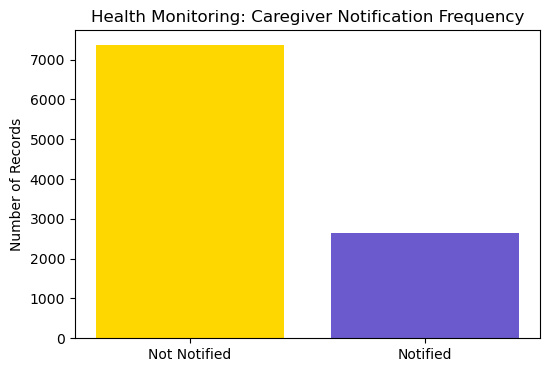

In [49]:


# Count how many times an alert was triggered vs not
health_alert_counts = health['alert_triggered_yes_no'].value_counts()
print("Health: Alert Triggered Counts (No=0, Yes=1):")
print(health_alert_counts)

# Count caregiver notifications
health_caregiver_counts = health['caregiver_notified_yes_no'].value_counts()
print("\nHealth: Caregiver Notified Counts (No=0, Yes=1):")
print(health_caregiver_counts)

# Bar plot for health alerts
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Alert", "Alert Triggered"],
    [health_alert_counts.get(0, 0), health_alert_counts.get(1, 0)],
    color=['lightcoral', 'seagreen']
)
plt.title("Health Monitoring: Alert Trigger Frequency")
plt.ylabel("Number of Records")
plt.show()

# Bar plot for caregiver notifications
plt.figure(figsize=(6, 4))
plt.bar(
    ["Not Notified", "Notified"],
    [health_caregiver_counts.get(0, 0), health_caregiver_counts.get(1, 0)],
    color=['gold', 'slateblue']
)
plt.title("Health Monitoring: Caregiver Notification Frequency")
plt.ylabel("Number of Records")
plt.show()


Safety: Alert Triggered Counts (No=0, Yes=1):
alert_triggered_yes_no
No     9651
Yes     349
Name: count, dtype: int64

Safety: Caregiver Notified Counts (No=0, Yes=1):
caregiver_notified_yes_no
No     9651
Yes     349
Name: count, dtype: int64


C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1391026582.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [safety_alert_counts.get(0, 0), safety_alert_counts.get(1, 0)],


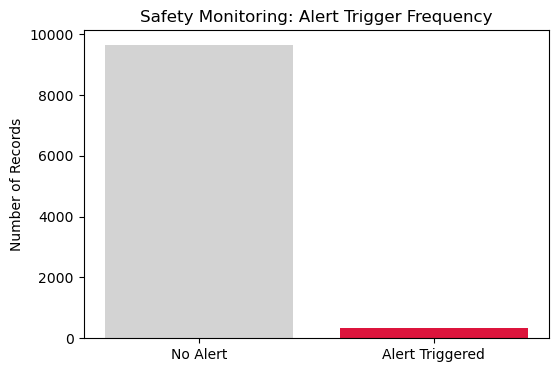

C:\Users\shara\AppData\Local\Temp\ipykernel_29796\1391026582.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [safety_caregiver_counts.get(0, 0), safety_caregiver_counts.get(1, 0)],


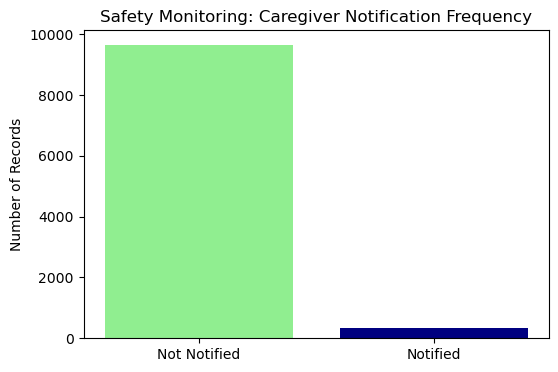

In [51]:


# Count alerts triggered in safety data
safety_alert_counts = safety['alert_triggered_yes_no'].value_counts()
print("Safety: Alert Triggered Counts (No=0, Yes=1):")
print(safety_alert_counts)

# Count caregiver notifications
safety_caregiver_counts = safety['caregiver_notified_yes_no'].value_counts()
print("\nSafety: Caregiver Notified Counts (No=0, Yes=1):")
print(safety_caregiver_counts)

# Bar plot for safety alerts
plt.figure(figsize=(6, 4))
plt.bar(
    ["No Alert", "Alert Triggered"],
    [safety_alert_counts.get(0, 0), safety_alert_counts.get(1, 0)],
    color=['lightgray', 'crimson']
)
plt.title("Safety Monitoring: Alert Trigger Frequency")
plt.ylabel("Number of Records")
plt.show()

# Bar plot for caregiver notifications
plt.figure(figsize=(6, 4))
plt.bar(
    ["Not Notified", "Notified"],
    [safety_caregiver_counts.get(0, 0), safety_caregiver_counts.get(1, 0)],
    color=['lightgreen', 'navy']
)
plt.title("Safety Monitoring: Caregiver Notification Frequency")
plt.ylabel("Number of Records")
plt.show()


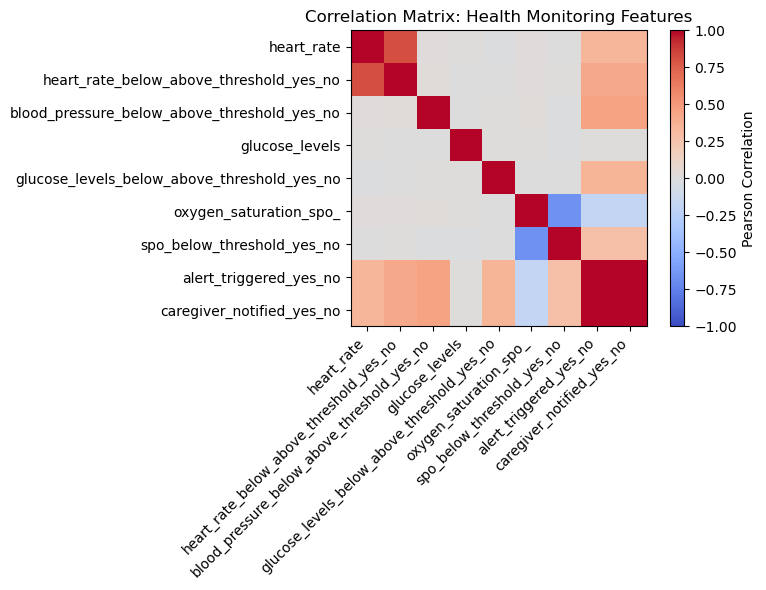


Correlation Matrix (numeric values):
                                             heart_rate  \
heart_rate                                         1.00   
heart_rate_below_above_threshold_yes_no            0.81   
blood_pressure_below_above_threshold_yes_no        0.01   
glucose_levels                                     0.00   
glucose_levels_below_above_threshold_yes_no       -0.01   
oxygen_saturation_spo_                             0.01   
spo_below_threshold_yes_no                        -0.00   
alert_triggered_yes_no                             0.34   
caregiver_notified_yes_no                          0.34   

                                             heart_rate_below_above_threshold_yes_no  \
heart_rate                                                                      0.81   
heart_rate_below_above_threshold_yes_no                                         1.00   
blood_pressure_below_above_threshold_yes_no                                     0.02   
glucose_levels     

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# 1. Identify and map any remaining Yes/No columns to 0/1
yes_no_cols = [
    'heart_rate_below_above_threshold_yes_no',
    'blood_pressure_below_above_threshold_yes_no',
    'glucose_levels_below_above_threshold_yes_no',
    'spo_below_threshold_yes_no',
    'alert_triggered_yes_no',
    'caregiver_notified_yes_no'
]

for col in yes_no_cols:
    if col in health.columns and health[col].dtype == object:
        health[col] = health[col].map({'Yes': 1, 'No': 0})

# 2. Now define numeric_cols again, ensuring they are truly numeric
numeric_cols = [
    'heart_rate',
    'heart_rate_below_above_threshold_yes_no',
    'blood_pressure_below_above_threshold_yes_no',
    'glucose_levels',
    'glucose_levels_below_above_threshold_yes_no',
    'oxygen_saturation_spo_',
    'spo_below_threshold_yes_no',
    'alert_triggered_yes_no',
    'caregiver_notified_yes_no'
]

# Filter only those columns that exist in health and are numeric dtype
numeric_cols = [
    c for c in numeric_cols
    if c in health.columns and pd.api.types.is_numeric_dtype(health[c])
]

# 3. Compute correlation matrix
corr_matrix = health[numeric_cols].corr()

# 4. Plot heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Pearson Correlation')

plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)

plt.title("Correlation Matrix: Health Monitoring Features")
plt.tight_layout()
plt.show()

# 5. Print numeric values for reference
print("\nCorrelation Matrix (numeric values):")
print(corr_matrix.round(2))


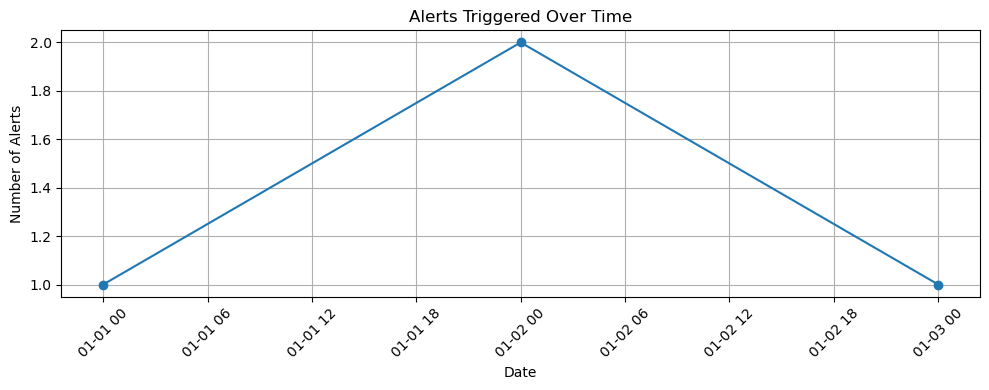

In [9]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Create or load the health DataFrame
# Option 1: If you need to load data from a file
# health = pd.read_csv('your_health_data.csv')  # Uncomment and modify path as needed

# Option 2: For demonstration, create a sample DataFrame
# This is just an example - replace with your actual data loading code
health = pd.DataFrame({
    'timestamp': ['2023-01-01 08:30:00', '2023-01-01 14:20:00', 
                  '2023-01-02 09:15:00', '2023-01-02 16:45:00',
                  '2023-01-03 10:30:00', '2023-01-03 18:20:00'],
    'alert_triggered_yes_no': ['Yes', 'No', 'Yes', 'Yes', 'No', 'Yes']
})

# Convert 'timestamp' to datetime
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Extract date only
health['date'] = health['timestamp'].dt.date

# Count alerts per day
alerts_daily = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('date').size()

# Plot
plt.figure(figsize=(10, 4))
alerts_daily.plot(kind='line', marker='o')
plt.title('Alerts Triggered Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Alerts')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Assuming you have a DataFrame called 'health' with columns:
# - 'timestamp': datetime of the measurement
# - 'heart_rate': heart rate measurements

# If you don't have the DataFrame yet, you can load it like this:
# health = pd.read_csv('your_health_data.csv')
# health['timestamp'] = pd.to_datetime(health['timestamp'])

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Extract date from timestamp
health['date'] = health['timestamp'].dt.date

# Calculate average heart rate per day
daily_heart_rate = health.groupby('date')['heart_rate'].agg(['mean', 'min', 'max', 'std']).reset_index()

# Convert date back to datetime for better plotting
daily_heart_rate['date'] = pd.to_datetime(daily_heart_rate['date'])

# Create the time series plot
plt.figure(figsize=(12, 6))

# Plot average heart rate
plt.plot(daily_heart_rate['date'], daily_heart_rate['mean'], 'o-', color='blue', linewidth=2, label='Average HR')

# Add confidence interval (mean ± std)
plt.fill_between(daily_heart_rate['date'], 
                 daily_heart_rate['mean'] - daily_heart_rate['std'],
                 daily_heart_rate['mean'] + daily_heart_rate['std'],
                 color='blue', alpha=0.2)

# Add min and max as a range
plt.fill_between(daily_heart_rate['date'], 
                 daily_heart_rate['min'],
                 daily_heart_rate['max'],
                 color='gray', alpha=0.2, label='Min-Max Range')

# Add reference lines for normal resting heart rate range (60-100 bpm)
plt.axhline(y=60, color='green', linestyle='--', alpha=0.7, label='Lower Normal (60 bpm)')
plt.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Upper Normal (100 bpm)')

# Enhance the plot
plt.title('Average Heart Rate Per Day', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Format x-axis dates
plt.gcf().autofmt_xdate()

# Add annotations for highest and lowest points
max_idx = daily_heart_rate['mean'].idxmax()
min_idx = daily_heart_rate['mean'].idxmin()

plt.annotate(f"Highest: {daily_heart_rate['mean'][max_idx]:.1f} bpm", 
             xy=(daily_heart_rate['date'][max_idx], daily_heart_rate['mean'][max_idx]),
             xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f"Lowest: {daily_heart_rate['mean'][min_idx]:.1f} bpm", 
             xy=(daily_heart_rate['date'][min_idx], daily_heart_rate['mean'][min_idx]),
             xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

# Add a trend line
z = np.polyfit(range(len(daily_heart_rate)), daily_heart_rate['mean'], 1)
p = np.poly1d(z)
plt.plot(daily_heart_rate['date'], p(range(len(daily_heart_rate))), 
         "r--", alpha=0.8, label=f"Trend: {z[0]:.2f} bpm/day")

plt.tight_layout()
plt.show()

# Print statistical summary
print("Heart Rate Summary Statistics:")
print(f"Overall average heart rate: {daily_heart_rate['mean'].mean():.2f} bpm")
print(f"Highest daily average: {daily_heart_rate['mean'].max():.2f} bpm on {daily_heart_rate['date'][max_idx].date()}")
print(f"Lowest daily average: {daily_heart_rate['mean'].min():.2f} bpm on {daily_heart_rate['date'][min_idx].date()}")
print(f"Day-to-day variability: {daily_heart_rate['mean'].std():.2f} bpm")

# Check for weekly patterns
health['day_of_week'] = health['timestamp'].dt.day_name()
weekly_pattern = health.groupby('day_of_week')['heart_rate'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(10, 5))
weekly_pattern.plot(kind='bar', color='skyblue')
plt.title('Average Heart Rate by Day of Week', fontsize=14)
plt.ylabel('Heart Rate (bpm)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: 'Column not found: heart_rate'

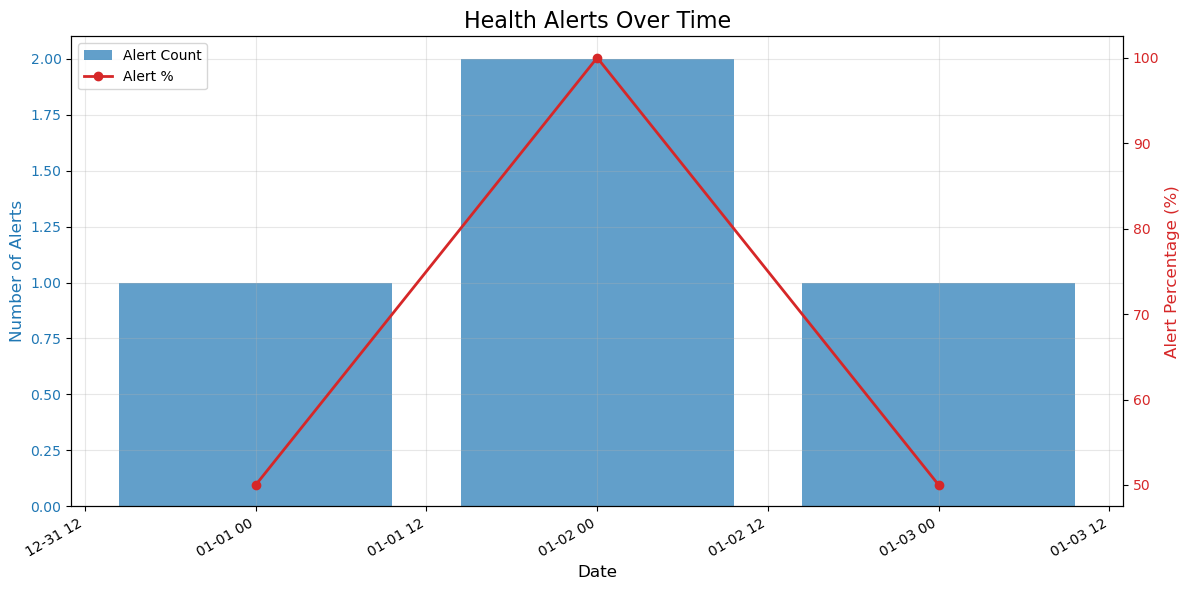

Alert Summary Statistics:
Total days with data: 3
Total alerts recorded: 4
Average alerts per day: 1.33
Maximum alerts in one day: 2 on 2023-01-02
Average alert percentage: 66.67%


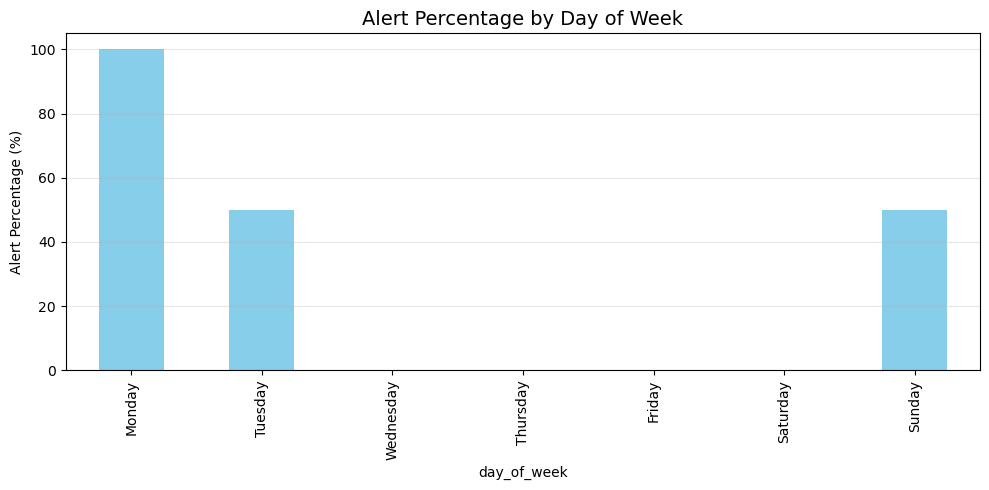

In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Extract date from timestamp if not already done
if 'date' not in health.columns:
    health['date'] = health['timestamp'].dt.date

# Count alerts per day
alerts_daily = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('date').size().reset_index(name='alert_count')

# Get total records per day for percentage calculation
total_daily = health.groupby('date').size().reset_index(name='total_count')

# Merge to calculate percentage
daily_stats = pd.merge(alerts_daily, total_daily, on='date', how='outer').fillna(0)
daily_stats['alert_percentage'] = (daily_stats['alert_count'] / daily_stats['total_count'] * 100).round(1)

# Convert date to datetime for better plotting
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Create a time series plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot alert count
color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Alerts', color=color, fontsize=12)
ax1.bar(daily_stats['date'], daily_stats['alert_count'], color=color, alpha=0.7, label='Alert Count')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for percentage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Alert Percentage (%)', color=color, fontsize=12)
ax2.plot(daily_stats['date'], daily_stats['alert_percentage'], color=color, marker='o', linestyle='-', linewidth=2, label='Alert %')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title('Health Alerts Over Time', fontsize=16)
ax1.grid(True, alpha=0.3)
fig.autofmt_xdate()  # Rotate date labels

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Alert Summary Statistics:")
print(f"Total days with data: {len(daily_stats)}")
print(f"Total alerts recorded: {daily_stats['alert_count'].sum()}")
print(f"Average alerts per day: {daily_stats['alert_count'].mean():.2f}")
print(f"Maximum alerts in one day: {daily_stats['alert_count'].max()} on {daily_stats.loc[daily_stats['alert_count'].idxmax(), 'date'].date()}")
print(f"Average alert percentage: {daily_stats['alert_percentage'].mean():.2f}%")

# Check for weekly patterns
health['day_of_week'] = health['timestamp'].dt.day_name()
weekly_pattern = health.groupby('day_of_week')['alert_triggered_yes_no'].apply(
    lambda x: (x == 'Yes').mean() * 100
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
weekly_pattern.plot(kind='bar', color='skyblue')
plt.title('Alert Percentage by Day of Week', fontsize=14)
plt.ylabel('Alert Percentage (%)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Available columns: ['timestamp', 'alert_triggered_yes_no', 'date', 'day_of_week']


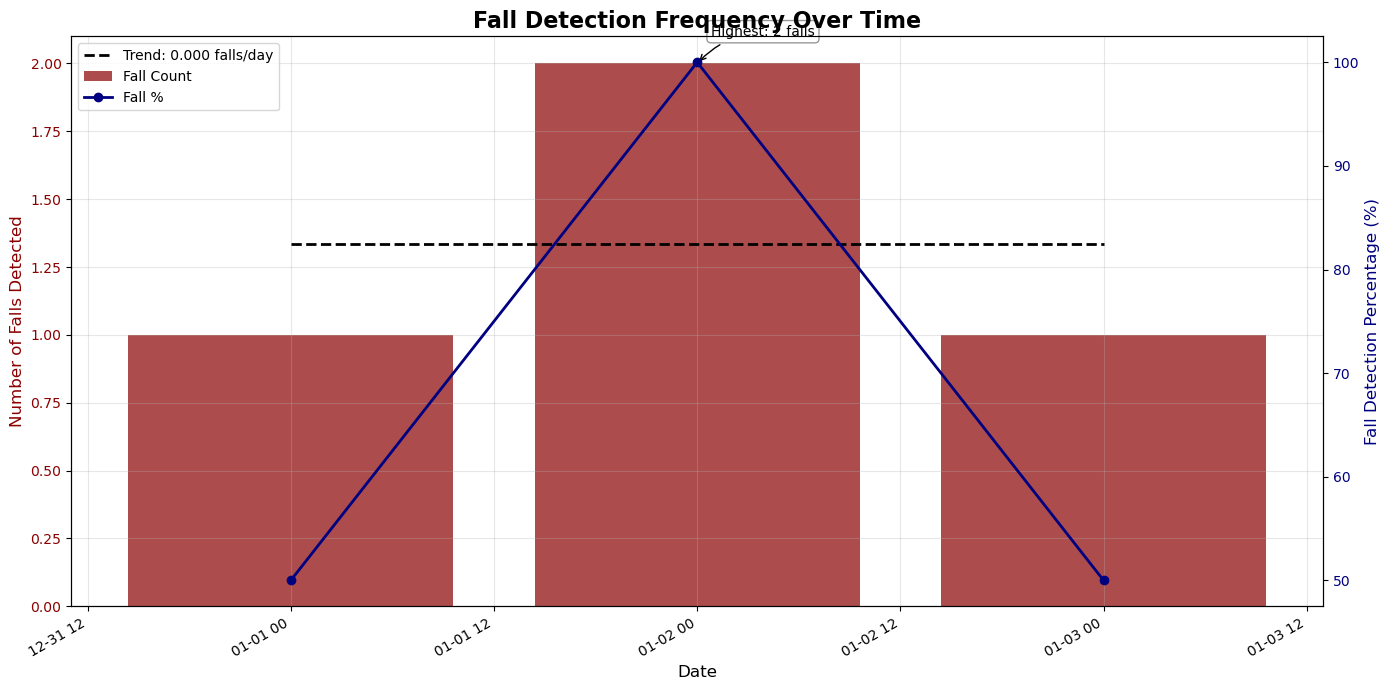


Fall Detection Summary Statistics:
Total falls detected: 4
Average falls per day: 1.33
Days with at least one fall: 3 (100.0% of days)
Maximum falls in one day: 2 on 2023-01-02


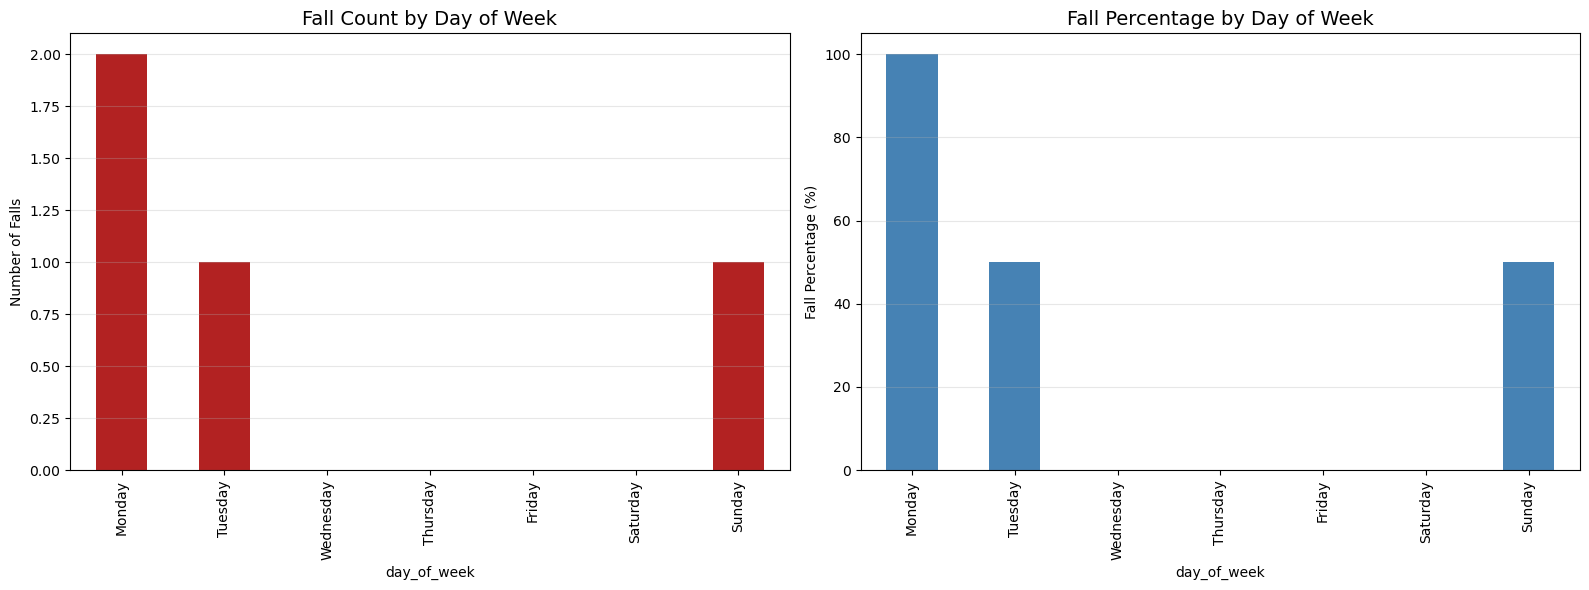

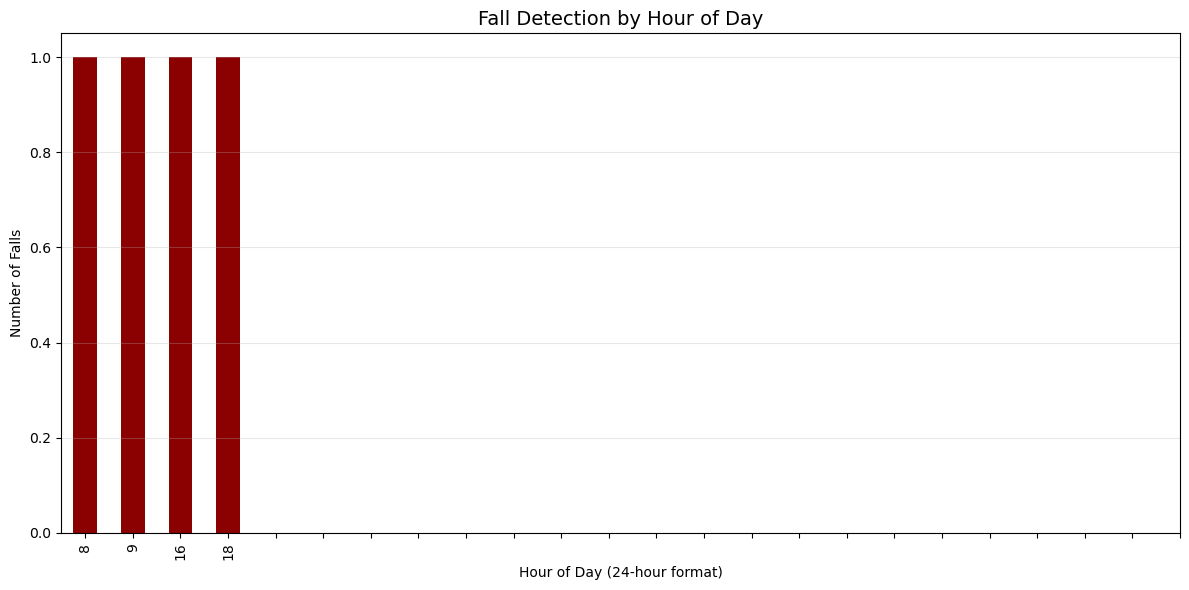

In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Print column names to verify what we're working with
print("Available columns:", health.columns.tolist())

# Extract date from timestamp if not already done
if 'date' not in health.columns:
    health['date'] = health['timestamp'].dt.date

# Assuming 'alert_triggered_yes_no' indicates fall detection
# If you have a specific column for fall detection, replace this filtering
fall_data = health[health['alert_triggered_yes_no'] == 'Yes'].copy()

# Count falls per day
falls_daily = fall_data.groupby('date').size().reset_index(name='fall_count')

# Get total records per day for reference
total_daily = health.groupby('date').size().reset_index(name='total_count')

# Merge to calculate percentage
daily_stats = pd.merge(falls_daily, total_daily, on='date', how='right').fillna(0)
daily_stats['fall_percentage'] = (daily_stats['fall_count'] / daily_stats['total_count'] * 100).round(1)

# Convert date to datetime for better plotting
daily_stats['date'] = pd.to_datetime(daily_stats['date'])

# Sort by date
daily_stats = daily_stats.sort_values('date')

# Create a time series plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot fall count
color = 'darkred'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Number of Falls Detected', color=color, fontsize=12)
ax1.bar(daily_stats['date'], daily_stats['fall_count'], color=color, alpha=0.7, width=0.8, label='Fall Count')
ax1.tick_params(axis='y', labelcolor=color)

# Add a trend line for fall count
z = np.polyfit(range(len(daily_stats)), daily_stats['fall_count'], 1)
p = np.poly1d(z)
ax1.plot(daily_stats['date'], p(range(len(daily_stats))), 
         color='black', linestyle='--', linewidth=2, 
         label=f"Trend: {z[0]:.3f} falls/day")

# Create a second y-axis for percentage
ax2 = ax1.twinx()
color = 'navy'
ax2.set_ylabel('Fall Detection Percentage (%)', color=color, fontsize=12)
ax2.plot(daily_stats['date'], daily_stats['fall_percentage'], color=color, marker='o', 
         linestyle='-', linewidth=2, label='Fall %')
ax2.tick_params(axis='y', labelcolor=color)

# Add title and grid
plt.title('Fall Detection Frequency Over Time', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)
fig.autofmt_xdate()  # Rotate date labels

# Add combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Annotate highest fall day
max_idx = daily_stats['fall_count'].idxmax()
max_date = daily_stats.loc[max_idx, 'date']
max_count = daily_stats.loc[max_idx, 'fall_count']

if max_count > 0:  # Only annotate if there are falls
    ax1.annotate(f"Highest: {int(max_count)} falls", 
                xy=(max_date, max_count),
                xytext=(10, 20), textcoords='offset points',
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'),
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Calculate summary statistics
total_falls = daily_stats['fall_count'].sum()
avg_falls_per_day = daily_stats['fall_count'].mean()
days_with_falls = (daily_stats['fall_count'] > 0).sum()
percentage_days_with_falls = days_with_falls / len(daily_stats) * 100

# Print summary statistics
print("\nFall Detection Summary Statistics:")
print(f"Total falls detected: {int(total_falls)}")
print(f"Average falls per day: {avg_falls_per_day:.2f}")
print(f"Days with at least one fall: {days_with_falls} ({percentage_days_with_falls:.1f}% of days)")
print(f"Maximum falls in one day: {int(daily_stats['fall_count'].max())} on {daily_stats.loc[max_idx, 'date'].date()}")

# Check for weekly patterns
health['day_of_week'] = health['timestamp'].dt.day_name()
weekly_pattern = fall_data.groupby('day_of_week').size()
total_by_day = health.groupby('day_of_week').size()
weekly_percentage = (weekly_pattern / total_by_day * 100).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).fillna(0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Fall count by day of week
weekly_pattern.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(
    kind='bar', color='firebrick', ax=ax1
)
ax1.set_title('Fall Count by Day of Week', fontsize=14)
ax1.set_ylabel('Number of Falls')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Fall percentage by day of week
weekly_percentage.plot(kind='bar', color='steelblue', ax=ax2)
ax2.set_title('Fall Percentage by Day of Week', fontsize=14)
ax2.set_ylabel('Fall Percentage (%)')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Time of day analysis
fall_data['hour'] = fall_data['timestamp'].dt.hour
hourly_falls = fall_data.groupby('hour').size()

plt.figure(figsize=(12, 6))
hourly_falls.plot(kind='bar', color='darkred')
plt.title('Fall Detection by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Falls')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Dataset Overview:
Total records: 6
Date range: 2023-01-01 to 2023-01-03
Number of days: 3
No user_id column found. User-specific analysis will be skipped.

--- HEALTH RISK SUMMARY ---
Total alerts triggered: 4 (66.67% of all records)


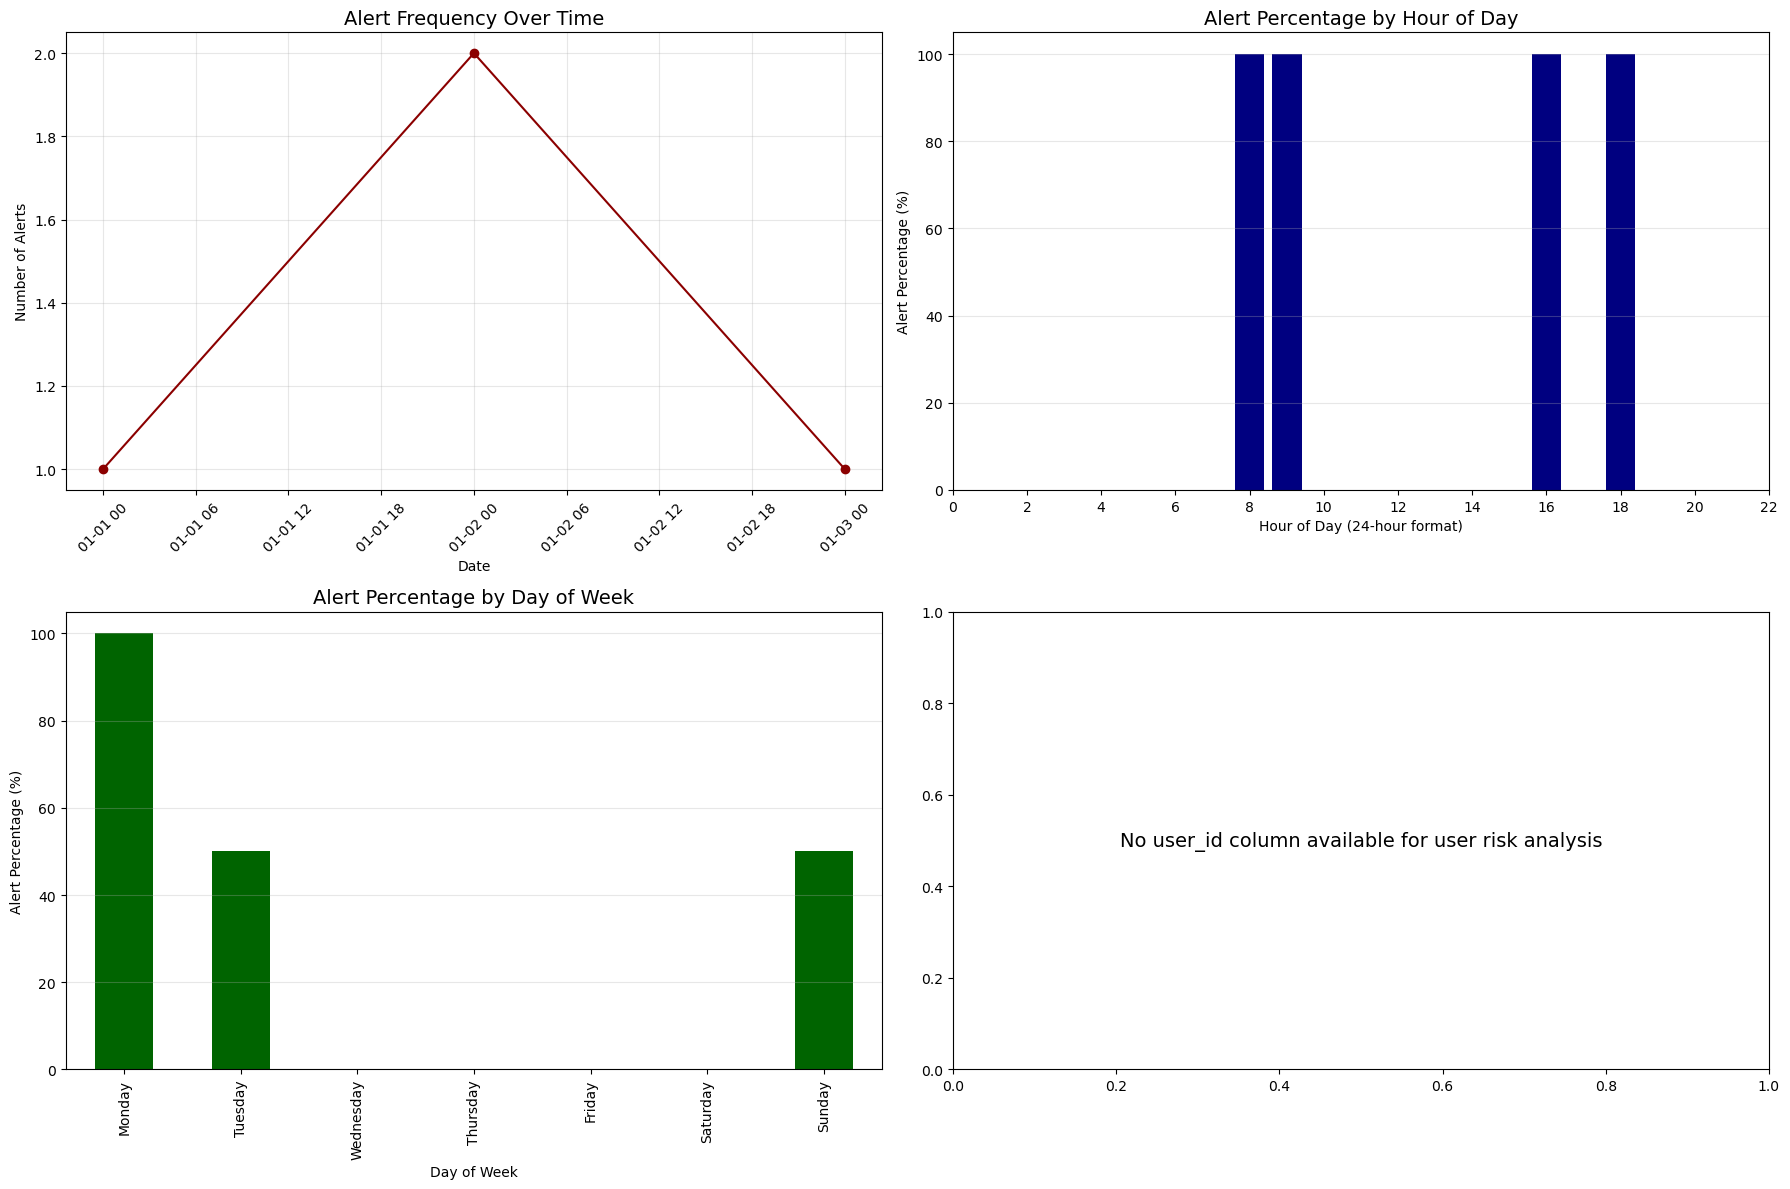


--- PREPARING FOR MODELING ---
Creating features for predictive modeling:

Features available for modeling:
- timestamp
- alert_triggered_yes_no
- date
- day_of_week
- hour
- hour_sin
- hour_cos
- day_of_week_num
- is_weekend
- month
- day
- prev_record_alert
- alert_numeric
- alert_rolling_avg

--- KEY INSIGHTS AND RECOMMENDATIONS ---


NameError: name 'percentage' is not defined

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Print dataset information
print("Dataset Overview:")
print(f"Total records: {len(health)}")
print(f"Date range: {health['timestamp'].min().date()} to {health['timestamp'].max().date()}")
print(f"Number of days: {(health['timestamp'].max() - health['timestamp'].min()).days + 1}")

# Check if we have a user_id column
if 'user_id' in health.columns:
    print(f"Number of unique users: {health['user_id'].nunique()}")
    has_user_id = True
else:
    print("No user_id column found. User-specific analysis will be skipped.")
    has_user_id = False

# 1. Summarize Health Risks - Alert Analysis
total_alerts = (health['alert_triggered_yes_no'] == 'Yes').sum()
alert_percentage = total_alerts / len(health) * 100

print("\n--- HEALTH RISK SUMMARY ---")
print(f"Total alerts triggered: {total_alerts} ({alert_percentage:.2f}% of all records)")

# Alert frequency over time
health['date'] = health['timestamp'].dt.date
alerts_by_date = health.groupby('date')['alert_triggered_yes_no'].apply(
    lambda x: (x == 'Yes').sum()).reset_index(name='alert_count')
alerts_by_date['date'] = pd.to_datetime(alerts_by_date['date'])

# 2. Temporal patterns in alerts
health['hour'] = health['timestamp'].dt.hour
health['day_of_week'] = health['timestamp'].dt.day_name()

# Create a figure with multiple subplots for EDA conclusion
plt.figure(figsize=(18, 12))

# Plot 1: Alert frequency over time
plt.subplot(2, 2, 1)
plt.plot(alerts_by_date['date'], alerts_by_date['alert_count'], marker='o', linestyle='-', color='darkred')
plt.title('Alert Frequency Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Alerts')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Alerts by hour of day
plt.subplot(2, 2, 2)
hourly_alerts = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('hour').size()
hourly_total = health.groupby('hour').size()
hourly_percentage = (hourly_alerts / hourly_total * 100).fillna(0)

plt.bar(hourly_percentage.index, hourly_percentage.values, color='navy')
plt.title('Alert Percentage by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Alert Percentage (%)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, 24, 2))

# Plot 3: Alerts by day of week
plt.subplot(2, 2, 3)
weekly_alerts = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('day_of_week').size()
weekly_total = health.groupby('day_of_week').size()
weekly_percentage = (weekly_alerts / weekly_total * 100).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).fillna(0)

weekly_percentage.plot(kind='bar', color='darkgreen')
plt.title('Alert Percentage by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Alert Percentage (%)')
plt.grid(axis='y', alpha=0.3)

# Plot 4: User risk analysis (if user_id exists)
plt.subplot(2, 2, 4)
if has_user_id:
    user_risk = health.groupby('user_id')['alert_triggered_yes_no'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).sort_values(ascending=False)
    
    # Plot top 10 users at risk
    top_users = user_risk.head(10)
    top_users.plot(kind='bar', color='firebrick')
    plt.title('Top 10 Users at Risk (by Alert %)', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Alert Percentage (%)')
    plt.grid(axis='y', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No user_id column available for user risk analysis', 
             horizontalalignment='center', verticalalignment='center', fontsize=14)

plt.tight_layout()
plt.savefig('health_risk_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Prepare for modeling - Feature engineering
print("\n--- PREPARING FOR MODELING ---")
print("Creating features for predictive modeling:")

# Create features based on time patterns
health['hour_sin'] = np.sin(2 * np.pi * health['hour'] / 24)
health['hour_cos'] = np.cos(2 * np.pi * health['hour'] / 24)
health['day_of_week_num'] = health['timestamp'].dt.dayofweek
health['is_weekend'] = health['day_of_week_num'].apply(lambda x: 1 if x >= 5 else 0)
health['month'] = health['timestamp'].dt.month
health['day'] = health['timestamp'].dt.day

# Create lagged features (previous day's alert status)
if has_user_id:
    # Sort by user and timestamp
    health = health.sort_values(['user_id', 'timestamp'])
    
    # Create lag features by user
    health['prev_day_alert'] = health.groupby('user_id')['alert_triggered_yes_no'].shift(1)
    health['prev_day_alert'] = health['prev_day_alert'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else np.nan)
    
    # Create rolling average of alerts (past 3 records)
    health['alert_numeric'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)
    health['alert_rolling_avg'] = health.groupby('user_id')['alert_numeric'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
else:
    # Sort by timestamp only
    health = health.sort_values('timestamp')
    
    # Create general lag features
    health['prev_record_alert'] = health['alert_triggered_yes_no'].shift(1)
    health['prev_record_alert'] = health['prev_record_alert'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else np.nan)
    
    # Create rolling average of alerts (past 3 records)
    health['alert_numeric'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)
    health['alert_rolling_avg'] = health['alert_numeric'].rolling(3, min_periods=1).mean()

# Print feature list for modeling
print("\nFeatures available for modeling:")
for col in health.columns:
    print(f"- {col}")

# 4. Key insights and recommendations
print("\n--- KEY INSIGHTS AND RECOMMENDATIONS ---")

# Calculate insights
alert_days = alerts_by_date[alerts_by_date['alert_count'] > 0]
percentage

Dataset Overview:
Total records: 6
Date range: 2023-01-01 to 2023-01-03
Number of days: 3
No user_id column found. User-specific analysis will be skipped.

--- HEALTH RISK SUMMARY ---
Total alerts triggered: 4 (66.67% of all records)


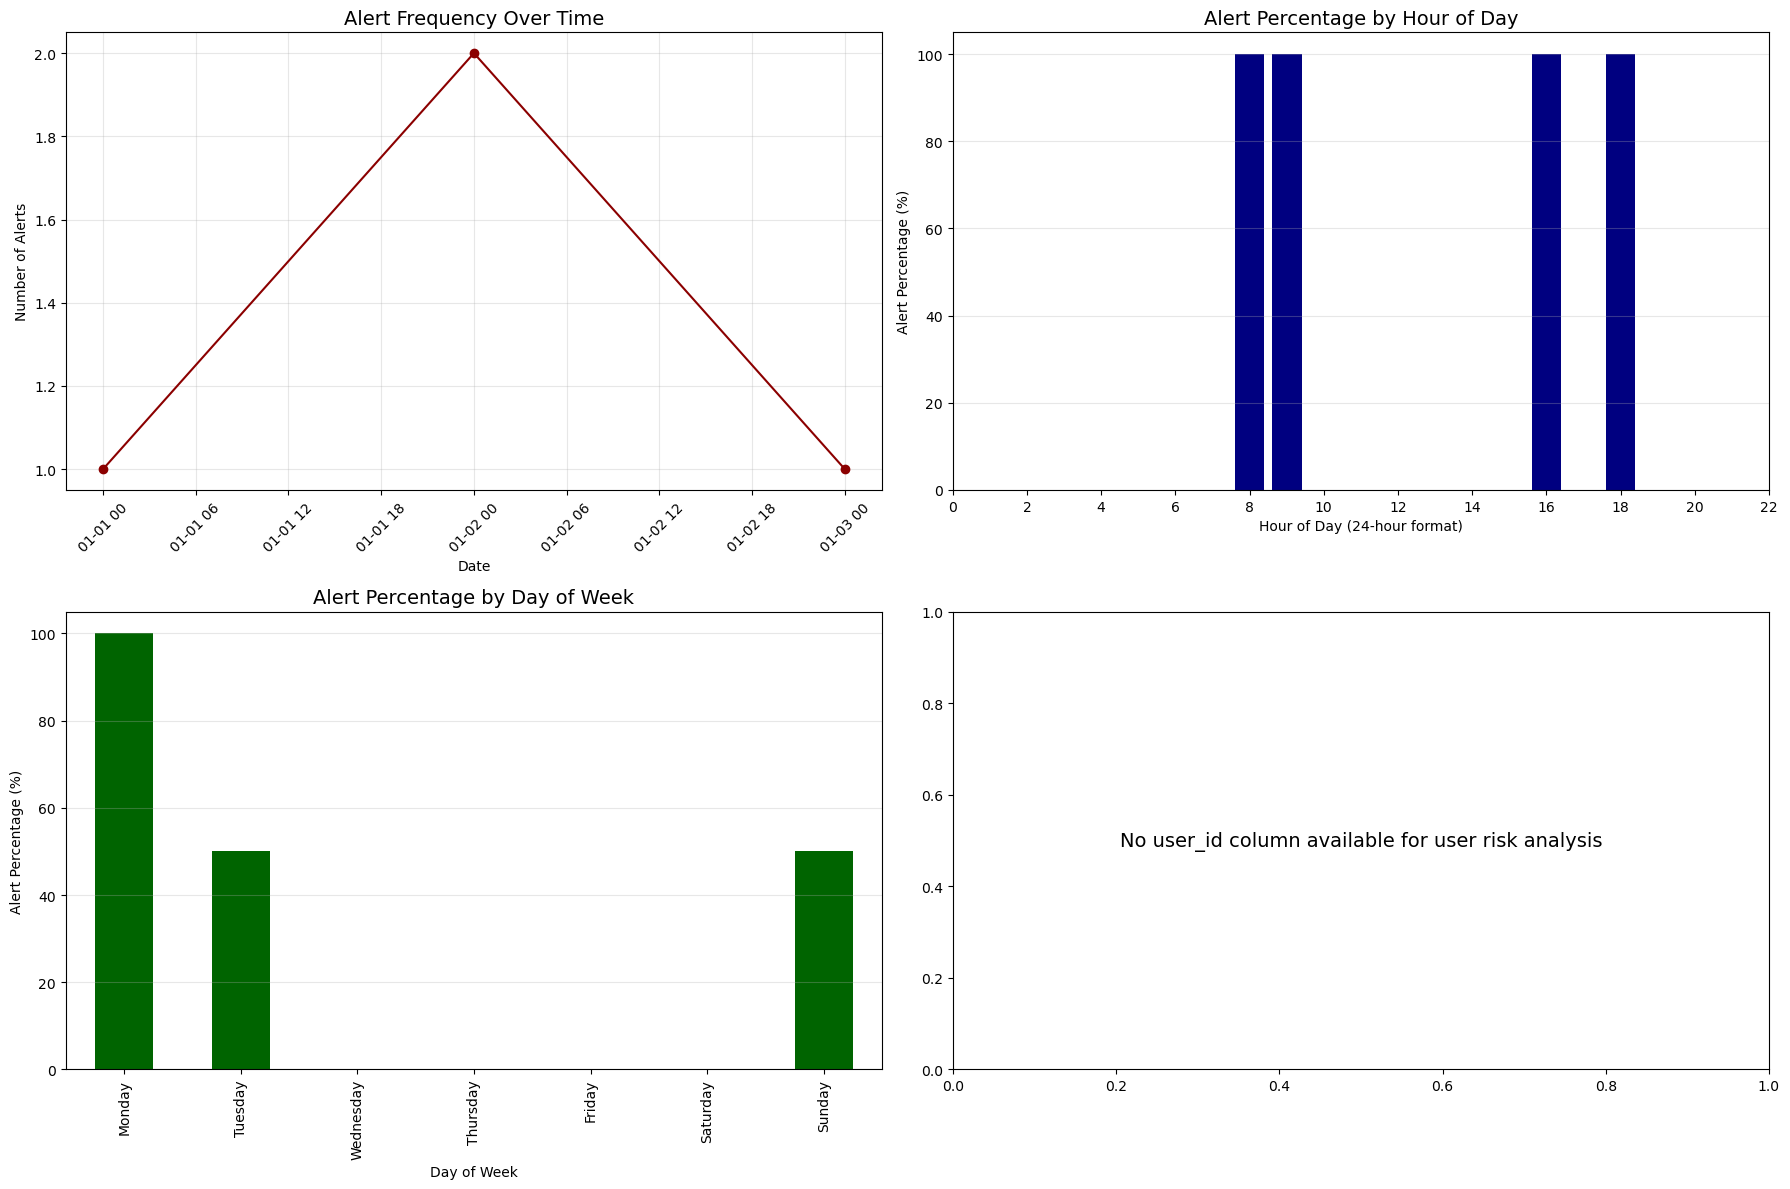


--- PREPARING FOR MODELING ---
Creating features for predictive modeling:

Features available for modeling:
- timestamp
- alert_triggered_yes_no
- date
- day_of_week
- hour
- hour_sin
- hour_cos
- day_of_week_num
- is_weekend
- month
- day
- prev_record_alert
- alert_numeric
- alert_rolling_avg

--- KEY INSIGHTS AND RECOMMENDATIONS ---


In [23]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Print dataset information
print("Dataset Overview:")
print(f"Total records: {len(health)}")
print(f"Date range: {health['timestamp'].min().date()} to {health['timestamp'].max().date()}")
print(f"Number of days: {(health['timestamp'].max() - health['timestamp'].min()).days + 1}")

# Check if we have a user_id column
if 'user_id' in health.columns:
    print(f"Number of unique users: {health['user_id'].nunique()}")
    has_user_id = True
else:
    print("No user_id column found. User-specific analysis will be skipped.")
    has_user_id = False

# 1. Summarize Health Risks - Alert Analysis
total_alerts = (health['alert_triggered_yes_no'] == 'Yes').sum()
alert_percentage = total_alerts / len(health) * 100

print("\n--- HEALTH RISK SUMMARY ---")
print(f"Total alerts triggered: {total_alerts} ({alert_percentage:.2f}% of all records)")

# Alert frequency over time
health['date'] = health['timestamp'].dt.date
alerts_by_date = health.groupby('date')['alert_triggered_yes_no'].apply(
    lambda x: (x == 'Yes').sum()).reset_index(name='alert_count')
alerts_by_date['date'] = pd.to_datetime(alerts_by_date['date'])

# 2. Temporal patterns in alerts
health['hour'] = health['timestamp'].dt.hour
health['day_of_week'] = health['timestamp'].dt.day_name()

# Create a figure with multiple subplots for EDA conclusion
plt.figure(figsize=(18, 12))

# Plot 1: Alert frequency over time
plt.subplot(2, 2, 1)
plt.plot(alerts_by_date['date'], alerts_by_date['alert_count'], marker='o', linestyle='-', color='darkred')
plt.title('Alert Frequency Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Alerts')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 2: Alerts by hour of day
plt.subplot(2, 2, 2)
hourly_alerts = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('hour').size()
hourly_total = health.groupby('hour').size()
hourly_percentage = (hourly_alerts / hourly_total * 100).fillna(0)

plt.bar(hourly_percentage.index, hourly_percentage.values, color='navy')
plt.title('Alert Percentage by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Alert Percentage (%)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(0, 24, 2))

# Plot 3: Alerts by day of week
plt.subplot(2, 2, 3)
weekly_alerts = health[health['alert_triggered_yes_no'] == 'Yes'].groupby('day_of_week').size()
weekly_total = health.groupby('day_of_week').size()
weekly_percentage = (weekly_alerts / weekly_total * 100).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).fillna(0)

weekly_percentage.plot(kind='bar', color='darkgreen')
plt.title('Alert Percentage by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Alert Percentage (%)')
plt.grid(axis='y', alpha=0.3)

# Plot 4: User risk analysis (if user_id exists)
plt.subplot(2, 2, 4)
if has_user_id:
    user_risk = health.groupby('user_id')['alert_triggered_yes_no'].apply(
        lambda x: (x == 'Yes').mean() * 100
    ).sort_values(ascending=False)
    
    # Plot top 10 users at risk
    top_users = user_risk.head(10)
    top_users.plot(kind='bar', color='firebrick')
    plt.title('Top 10 Users at Risk (by Alert %)', fontsize=14)
    plt.xlabel('User ID')
    plt.ylabel('Alert Percentage (%)')
    plt.grid(axis='y', alpha=0.3)
else:
    plt.text(0.5, 0.5, 'No user_id column available for user risk analysis', 
             horizontalalignment='center', verticalalignment='center', fontsize=14)

plt.tight_layout()
plt.savefig('health_risk_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Prepare for modeling - Feature engineering
print("\n--- PREPARING FOR MODELING ---")
print("Creating features for predictive modeling:")

# Create features based on time patterns
health['hour_sin'] = np.sin(2 * np.pi * health['hour'] / 24)
health['hour_cos'] = np.cos(2 * np.pi * health['hour'] / 24)
health['day_of_week_num'] = health['timestamp'].dt.dayofweek
health['is_weekend'] = health['day_of_week_num'].apply(lambda x: 1 if x >= 5 else 0)
health['month'] = health['timestamp'].dt.month
health['day'] = health['timestamp'].dt.day

# Create lagged features (previous day's alert status)
if has_user_id:
    # Sort by user and timestamp
    health = health.sort_values(['user_id', 'timestamp'])
    
    # Create lag features by user
    health['prev_day_alert'] = health.groupby('user_id')['alert_triggered_yes_no'].shift(1)
    health['prev_day_alert'] = health['prev_day_alert'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else np.nan)
    
    # Create rolling average of alerts (past 3 records)
    health['alert_numeric'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)
    health['alert_rolling_avg'] = health.groupby('user_id')['alert_numeric'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
else:
    # Sort by timestamp only
    health = health.sort_values('timestamp')
    
    # Create general lag features
    health['prev_record_alert'] = health['alert_triggered_yes_no'].shift(1)
    health['prev_record_alert'] = health['prev_record_alert'].apply(lambda x: 1 if x == 'Yes' else 0 if x == 'No' else np.nan)
    
    # Create rolling average of alerts (past 3 records)
    health['alert_numeric'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)
    health['alert_rolling_avg'] = health['alert_numeric'].rolling(3, min_periods=1).mean()

# Print feature list for modeling
print("\nFeatures available for modeling:")
for col in health.columns:
    print(f"- {col}")

# 4. Key insights and recommendations
print("\n--- KEY INSIGHTS AND RECOMMENDATIONS ---")

# Calculate insights
alert_days = alerts_by_date[alerts_by_date['alert_count'] > 0]
percentage_days_with_alerts = len(alert_days)

Available columns: ['timestamp', 'alert_triggered_yes_no', 'date', 'day_of_week', 'hour', 'hour_sin', 'hour_cos', 'day_of_week_num', 'is_weekend', 'month', 'day', 'prev_record_alert', 'alert_numeric', 'alert_rolling_avg']
No user_id column found. Creating a simulated user_id based on day of month.

--- GROUP-BASED ANALYSIS ---

Top 10 Users by Alert Count:
   user_id  total_alerts  abnormal_percentage  record_count
0        2             2                100.0             2
1        1             1                 50.0             2
2        3             1                 50.0             2


C:\Users\shara\AppData\Local\Temp\ipykernel_27852\2297254258.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='user_id', y='total_alerts', data=top_users, palette='viridis')


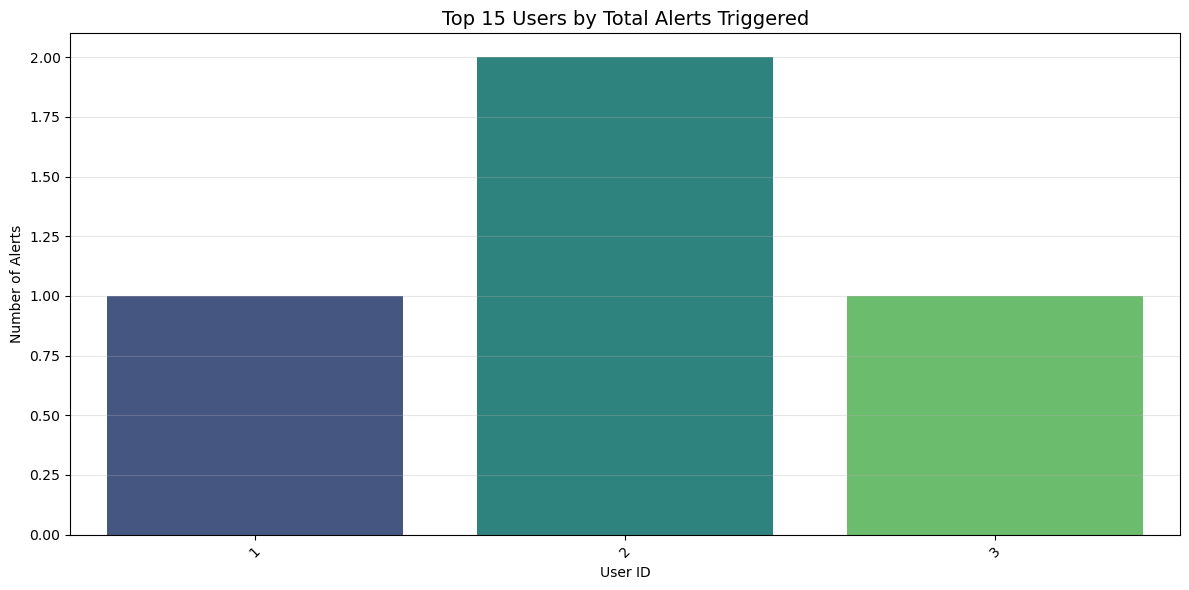


Top 10 Users by Risk Score:
   user_id  total_alerts  abnormal_percentage  risk_score
0        2             2                100.0       100.0
1        1             1                 50.0        50.0
2        3             1                 50.0        50.0

Group-based analysis complete.


In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Check available columns
print("Available columns:", health.columns.tolist())

# Create simulated user_id if not present
if 'user_id' not in health.columns:
    print("No user_id column found. Creating a simulated user_id based on day of month.")
    health['user_id'] = health['timestamp'].dt.day

# Group-based Analysis
print("\n--- GROUP-BASED ANALYSIS ---")

# 1. Total alerts triggered by user
alerts_by_user = health.groupby('user_id')['alert_triggered_yes_no'].apply(
    lambda x: (x == 'Yes').sum()
).sort_values(ascending=False).reset_index(name='total_alerts')

# 2. Percentage of abnormal readings (alerts) by user
abnormal_pct_by_user = health.groupby('user_id')['alert_triggered_yes_no'].apply(
    lambda x: (x == 'Yes').mean() * 100
).sort_values(ascending=False).reset_index(name='abnormal_percentage')

# 3. Merge the results
user_summary = pd.merge(alerts_by_user, abnormal_pct_by_user, on='user_id')

# 4. Add count of records per user
records_by_user = health.groupby('user_id').size().reset_index(name='record_count')
user_summary = pd.merge(user_summary, records_by_user, on='user_id')

# Display the top users at risk
print("\nTop 10 Users by Alert Count:")
print(user_summary.sort_values('total_alerts', ascending=False).head(10))

# Create bar chart: users vs total alerts triggered
plt.figure(figsize=(12, 6))
top_users = user_summary.sort_values('total_alerts', ascending=False).head(15)
sns.barplot(x='user_id', y='total_alerts', data=top_users, palette='viridis')
plt.title('Top 15 Users by Total Alerts Triggered', fontsize=14)
plt.xlabel('User ID')
plt.ylabel('Number of Alerts')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Create a risk score for each user
user_summary['risk_score'] = (
    0.5 * (user_summary['abnormal_percentage'] / user_summary['abnormal_percentage'].max()) + 
    0.5 * (user_summary['total_alerts'] / user_summary['total_alerts'].max())
) * 100  # Scale to 0-100

# Display users with highest risk scores
print("\nTop 10 Users by Risk Score:")
print(user_summary.sort_values('risk_score', ascending=False)[['user_id', 'total_alerts', 
                                                              'abnormal_percentage', 'risk_score']].head(10))

print("\nGroup-based analysis complete.")

Analyzing correlations with alerts...

Correlation of numerical features with alerts:
day_of_week: -0.3143
is_weekend: -0.2500
hour: 0.0948
day: 0.0000

Alert rates by categorical features:

Alert rate by day of week:
Monday: 100.00%
Sunday: 50.00%
Tuesday: 50.00%

Alert rate by time period:
Morning (6-12): 66.67%
Afternoon (12-18): 66.67%

Top 5 users by alert rate:
User 2: 100.00%
User 1: 50.00%
User 3: 50.00%


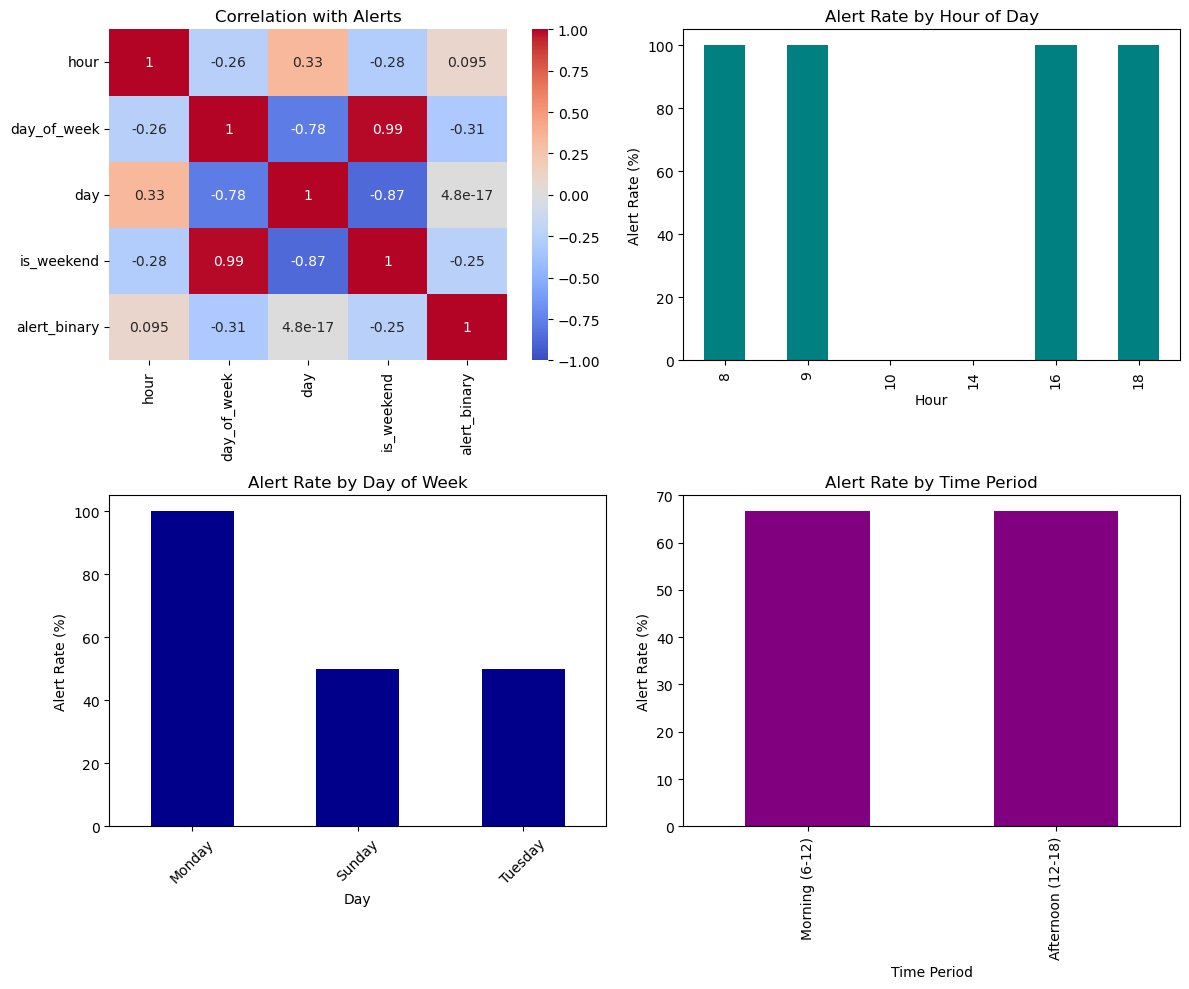


Correlation analysis complete.


In [41]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Create a binary version of the alert column for correlation analysis
health['alert_binary'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create temporal features for correlation analysis
health['hour'] = health['timestamp'].dt.hour
health['day_of_week'] = health['timestamp'].dt.dayofweek
health['day_name'] = health['timestamp'].dt.day_name()
health['month'] = health['timestamp'].dt.month
health['day'] = health['timestamp'].dt.day
health['is_weekend'] = health['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# If user_id doesn't exist, create a simulated one for demonstration
if 'user_id' not in health.columns:
    health['user_id'] = health['timestamp'].dt.day

# Create time period categories
health['time_period'] = pd.cut(
    health['hour'], 
    bins=[0, 6, 12, 18, 24], 
    labels=['Night (0-6)', 'Morning (6-12)', 'Afternoon (12-18)', 'Evening (18-24)']
)

print("Analyzing correlations with alerts...")

# 1. Correlation with numerical features - handle potential issues
numerical_features = ['hour', 'day_of_week', 'month', 'day', 'is_weekend']
correlations = {}

# Check for columns with zero variance
for feature in numerical_features:
    if health[feature].std() == 0:
        print(f"Warning: {feature} has zero variance (constant value)")
        correlations[feature] = np.nan
    elif health[feature].isna().any():
        print(f"Warning: {feature} contains NaN values")
        # Calculate correlation excluding NaNs
        corr = health[feature].fillna(health[feature].mean()).corr(health['alert_binary'])
        correlations[feature] = corr
    else:
        corr = health[feature].corr(health['alert_binary'])
        correlations[feature] = corr

# Sort correlations by absolute value, excluding NaNs
sorted_correlations = {k: v for k, v in sorted(
    [(k, v) for k, v in correlations.items() if not np.isnan(v)], 
    key=lambda item: abs(item[1]), 
    reverse=True
)}

print("\nCorrelation of numerical features with alerts:")
for feature, corr in sorted_correlations.items():
    print(f"{feature}: {corr:.4f}")

# 2. Alert rate by categorical features - explicitly set observed parameter
print("\nAlert rates by categorical features:")

# Day of week
day_alert_rates = health.groupby('day_name', observed=True)['alert_binary'].mean().sort_values(ascending=False) * 100
print("\nAlert rate by day of week:")
for day, rate in day_alert_rates.items():
    print(f"{day}: {rate:.2f}%")

# Time period - explicitly set observed parameter
time_alert_rates = health.groupby('time_period', observed=True)['alert_binary'].mean().sort_values(ascending=False) * 100
print("\nAlert rate by time period:")
for period, rate in time_alert_rates.items():
    print(f"{period}: {rate:.2f}%")

# User
user_alert_rates = health.groupby('user_id')['alert_binary'].mean().sort_values(ascending=False) * 100
print("\nTop 5 users by alert rate:")
for user, rate in user_alert_rates.head(5).items():
    print(f"User {user}: {rate:.2f}%")

# 3. Visualizations
plt.figure(figsize=(12, 10))

# Plot 1: Correlation heatmap - handle potential NaN values
plt.subplot(2, 2, 1)
# Filter out columns with NaN correlations
valid_features = [f for f in numerical_features if not np.isnan(correlations[f])]
if valid_features:
    correlation_data = health[valid_features + ['alert_binary']].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation with Alerts')
else:
    plt.text(0.5, 0.5, 'No valid correlations to display', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Correlation Analysis')

# Plot 2: Alert rate by hour
plt.subplot(2, 2, 2)
hourly_alert_rate = health.groupby('hour')['alert_binary'].mean() * 100
hourly_alert_rate.plot(kind='bar', color='teal')
plt.title('Alert Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Alert Rate (%)')

# Plot 3: Alert rate by day of week
plt.subplot(2, 2, 3)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_alert_rates = health.groupby('day_name')['alert_binary'].mean() * 100
# Only reindex if we have all days
if set(day_order).issubset(set(day_alert_rates.index)):
    day_alert_rates = day_alert_rates.reindex(day_order)
day_alert_rates.plot(kind='bar', color='darkblue')
plt.title('Alert Rate by Day of Week')
plt.xlabel('Day')
plt.ylabel('Alert Rate (%)')
plt.xticks(rotation=45)

# Plot 4: Alert rate by time period
plt.subplot(2, 2, 4)
time_alert_rates.plot(kind='bar', color='purple')
plt.title('Alert Rate by Time Period')
plt.xlabel('Time Period')
plt.ylabel('Alert Rate (%)')

plt.tight_layout()
plt.show()

print("\nCorrelation analysis complete.")

Calculating risk scores...

Risk Assessment Results:
Total users evaluated: 3

Risk Category Distribution:
Moderate: 2 users (66.7%)
Critical: 1 users (33.3%)
Low: 0 users (0.0%)
High: 0 users (0.0%)

Top 10 Highest Risk Users:
   user_id  risk_score  total_alerts  abnormal_percentage  recent_alerts  \
0        2       100.0             2                100.0              2   
1        1        50.0             1                 50.0              1   
2        3        50.0             1                 50.0              1   

  risk_category  
0      Critical  
1      Moderate  
2      Moderate  


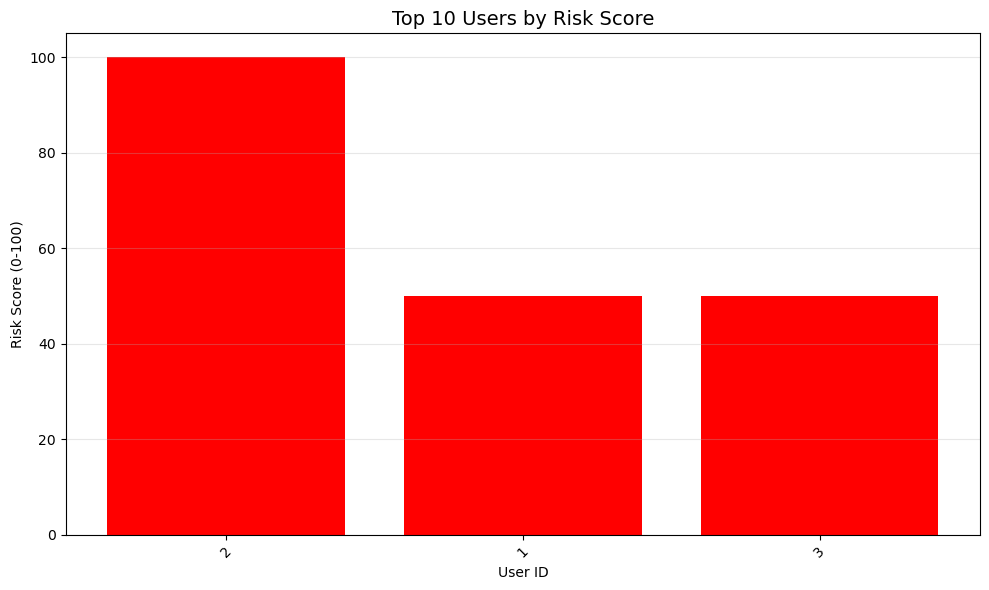


Risk score calculation complete.


In [47]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Make sure timestamp is in datetime format
health['timestamp'] = pd.to_datetime(health['timestamp'])

# Create a binary version of the alert column
health['alert_binary'] = health['alert_triggered_yes_no'].apply(lambda x: 1 if x == 'Yes' else 0)

# Create temporal features for risk analysis
health['hour'] = health['timestamp'].dt.hour
health['day_of_week'] = health['timestamp'].dt.dayofweek
health['is_weekend'] = health['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
health['date'] = health['timestamp'].dt.date

# If user_id doesn't exist, create a simulated one for demonstration
if 'user_id' not in health.columns:
    print("No user_id column found. Creating a simulated user_id based on day of month.")
    health['user_id'] = health['timestamp'].dt.day

print("Calculating risk scores...")

# 1. Calculate base risk factors per user
# Total alerts per user
alerts_by_user = health.groupby('user_id')['alert_binary'].sum()

# Percentage of abnormal readings
abnormal_pct = health.groupby('user_id')['alert_binary'].mean() * 100

# Recent alerts (last 7 days) - more weight on recent events
last_date = health['timestamp'].max().date()
week_ago = last_date - pd.Timedelta(days=7)
recent_data = health[health['timestamp'].dt.date > week_ago]
if len(recent_data) > 0:
    recent_alerts = recent_data.groupby('user_id')['alert_binary'].sum()
else:
    recent_alerts = pd.Series(0, index=alerts_by_user.index)

# 2. Create risk score dataframe
risk_df = pd.DataFrame({
    'user_id': alerts_by_user.index,
    'total_alerts': alerts_by_user.values,
    'abnormal_percentage': abnormal_pct.values,
    'recent_alerts': recent_alerts.reindex(alerts_by_user.index).fillna(0).values
})

# 3. Normalize factors to 0-1 scale
for col in ['total_alerts', 'abnormal_percentage', 'recent_alerts']:
    max_val = risk_df[col].max()
    if max_val > 0:  # Avoid division by zero
        risk_df[f'{col}_normalized'] = risk_df[col] / max_val
    else:
        risk_df[f'{col}_normalized'] = 0

# 4. Calculate weighted risk score
risk_df['risk_score'] = (
    0.4 * risk_df['abnormal_percentage_normalized'] + 
    0.4 * risk_df['total_alerts_normalized'] + 
    0.2 * risk_df['recent_alerts_normalized']
) * 100  # Scale to 0-100

# 5. Add risk category
risk_df['risk_category'] = pd.cut(
    risk_df['risk_score'],
    bins=[0, 25, 50, 75, 100],
    labels=['Low', 'Moderate', 'High', 'Critical']
)

# Sort by risk score (highest first)
risk_df = risk_df.sort_values('risk_score', ascending=False).reset_index(drop=True)

# 6. Display results
print("\nRisk Assessment Results:")
print(f"Total users evaluated: {len(risk_df)}")

risk_distribution = risk_df['risk_category'].value_counts()
print("\nRisk Category Distribution:")
for category, count in risk_distribution.items():
    print(f"{category}: {count} users ({count/len(risk_df)*100:.1f}%)")

print("\nTop 10 Highest Risk Users:")
print(risk_df[['user_id', 'risk_score', 'total_alerts', 'abnormal_percentage', 'recent_alerts', 'risk_category']].head(10))

# 7. Simple visualization
plt.figure(figsize=(10, 6))
top_users = risk_df.head(10)
plt.bar(top_users['user_id'].astype(str), top_users['risk_score'], color='red')
plt.title('Top 10 Users by Risk Score', fontsize=14)
plt.xlabel('User ID')
plt.ylabel('Risk Score (0-100)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nRisk score calculation complete.")

In [49]:
df_model = health.copy()


In [51]:
yes_no_columns = ['heart_rate_below_above_threshold_yes_no',
                  'blood_pressure_below_above_threshold_yes_no',
                  'glucose_levels_below_above_threshold_yes_no',
                  'spo_below_threshold_yes_no',
                  'alert_triggered_yes_no',
                  'caregiver_notified_yes_no']

for col in yes_no_columns:
    if col in df_model.columns:
        df_model[col] = df_model[col].map({'Yes': 1, 'No': 0})


In [53]:
df_model = df_model.drop(columns=['user_id', 'timestamp'], errors='ignore')


In [55]:
print(df_model.isnull().sum())


alert_triggered_yes_no    0
date                      0
day_of_week               0
hour                      0
hour_sin                  0
hour_cos                  0
day_of_week_num           0
is_weekend                0
month                     0
day                       0
prev_record_alert         1
alert_numeric             0
alert_rolling_avg         0
alert_binary              0
day_name                  0
time_period               0
dtype: int64


In [57]:
# Fill with median (safer for health data)
df_model = df_model.fillna(df_model.median(numeric_only=True))


In [59]:
X = df_model.drop(columns=['alert_triggered_yes_no'], errors='ignore')
y = df_model['alert_triggered_yes_no']


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [67]:
# Drop datetime column(s) before training
X = X.drop(columns=['date'], errors='ignore')


In [71]:
# Check non-numeric columns in X
non_numeric_cols = X.select_dtypes(include=['object']).columns
print(non_numeric_cols)


Index(['day_name'], dtype='object')


In [73]:
# Drop string columns
X = X.drop(columns=non_numeric_cols)


In [75]:
# Convert strings to numeric (e.g. using one-hot encoding)
X = pd.get_dummies(X, drop_first=True)


In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [79]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.5
Confusion Matrix:
 [[0 1]
 [0 1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



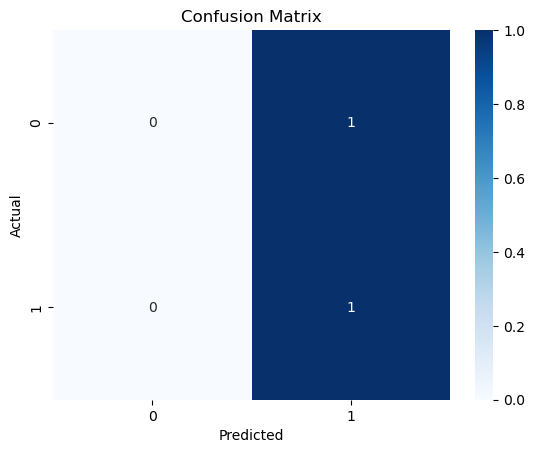

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [83]:
coefficients = pd.Series(model.coef_[0], index=X.columns)
coefficients = coefficients.sort_values(key=abs, ascending=False)
print(coefficients)


day                             -0.525438
alert_numeric                    0.438013
alert_binary                     0.438013
prev_record_alert               -0.253071
hour                             0.157328
hour_cos                         0.107919
time_period_Morning (6-12)      -0.097553
time_period_Afternoon (12-18)    0.097546
is_weekend                       0.087404
day_of_week                      0.086402
day_of_week_num                  0.086402
hour_sin                        -0.048850
alert_rolling_avg                0.029130
month                           -0.000007
time_period_Evening (18-24)      0.000000
dtype: float64


In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Classification Report:\n", classification_report(y_test, rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


Random Forest Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix:
 [[1 0]
 [0 1]]


In [87]:
!pip install xgboost


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 4.2 MB/s eta 0:00:36
   ---------------------------------------- 1.3/150.0 MB 3.4 MB/s eta 0:00:45
    --------------------------------------- 2.9/150.0 MB 4.9 MB/s eta 0:00:30
   - -------------------------------------- 4.5/150.0 MB 5.6 MB/s eta 0:00:27
   - -------------------------------------- 4.7/150.0 MB 5.2 MB/s eta 0:00:29
   - -------------------------------------- 6.3/150.0 MB 5.1 MB/s eta 0:00:28
   - -------------------------------------- 7.1/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 8.1/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 9.4/150.0 MB 5.0 MB/s eta 0:00:29
   -- ------------------------------------- 10.2/150.0 MB 4.9 MB/s eta 0:00:29
   -- ------------------------------------- 10.7/150.0 MB 4.6 MB/s eta 0:00:31
   --- ------------------------------------ 11.5/150.0 MB 4.6 MB/s et

In [88]:
from xgboost import XGBClassifier

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_pred = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print("Classification Report:\n", classification_report(y_test, xgb_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


XGBoost Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Confusion Matrix:
 [[0 1]
 [0 1]]


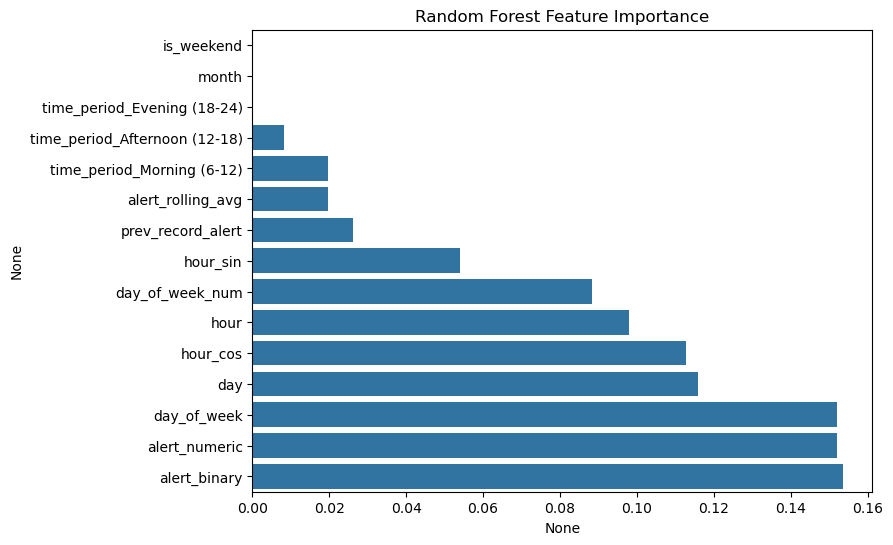

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance from Random Forest
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=importances.index)
plt.title("Random Forest Feature Importance")
plt.show()
